# GLOVe-Logistic Regression
- Uses logistic regression on GloVe embedding representation of tweets

In [1]:
## IMPORTS
# GLOVE Embeddings
import spacy

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

# GLOVE Embeddings
import spacy

# Preprocessing
import csv
import chardet
import numpy as np
import re
import pandas as pd
import demoji
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import json

# metrics
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/walnuts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the dataset / read csv
# MAKE SURE CSV IS IN UTF-8 (if tweets have emojis)

## Testing if csv can open (Use for troubleshooting)
# with open('Eng_Tweets.csv') as csv_file:
#   csvFile = csv.reader(csv_file, delimiter=',')
#   for row in csv_file:
#     print(row)

# RUN PARAMETERS
LANG = 1  # 1 = English | 2 = Tagalog | 3 = TagLish | 4 = Mixed

pd.set_option('display.max_colwidth', None)

# Assign the CSV path based on LANG value
if LANG == 1:
    csv_path = 'Eng_Tweets.csv'
elif LANG == 2:
    csv_path = 'Tag_Tweets.csv'
elif LANG == 3:
    csv_path = 'TagLish_Tweets.csv'
elif LANG == 4:
    csv_path = 'Mixed_Tweets.csv'
else:
    raise ValueError("Invalid value for LANG. Must be 1, 2, 3, or 4.")

df = pd.read_csv(csv_path)
print("total rows: " + str(len(df)))
df.head() ## head won't show emojis unless using print function

total rows: 2338


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going to attempt tonight i can't do this anymore i can't handle all this stress i wish i was never born bro,9/11/24,1
1,@yourdystiny,"Becoming less reactive is a huge part of growth & decreasing stress. If you let everything get you worked up, you’ll damage your mind, body & spirit.",9/8/24,0
2,@ocenhxu,me ??? tired ??? stressed ??? exhausted ??? i wanna cry ??? yes.,9/8/24,1
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired and drained. that's me, that's my everyday life",9/10/24,1
4,@ysuckme,"you deserve to be happy. not confused, not hurt, not stressed, just happy.",9/8/24,0


In [3]:
df.loc[22]

Username                                            @PaulKagame
Tweet          After this conversation no stress at all !!!😁😁😍😍
Date posted                                             2/24/23
Label                                                         0
Name: 22, dtype: object

In [4]:
df['Label'].value_counts()

Label
0    1897
1     441
Name: count, dtype: int64

## Preprocessing
- Remove mentions (@)
- Remove hashtags (#)
- Remove URLs
- Replace emojis with textual description (Using demoji)
- Remove stop words

In [5]:
### PREPROCESSING STEPS (FOR TAGALOG)
with open('tl_stopwords.json', 'r') as f:
    tagalog_stop_words = json.load(f)

# Preprocessing functions
def clean_text_tl(text):
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Replace emoji with textual descriptions
    text = demoji.replace_with_desc(text)
    text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text)  # Add spaces around the shortcode
    text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
    text = text.strip()
    return text

def remove_stopwords_tl(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in tagalog_stop_words]
    return ' '.join(filtered_words)

In [6]:
### PREPROCESSING STEPS
def clean_text(text):
  # Remove mentions
  text = re.sub(r'@[A-Za-z0-9_]+', '', text)
  # Remove hashtags
  text = re.sub(r'#\w+', '', text)
  # Remove URLs
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Replace emoji with textual descriptions
  text = demoji.replace_with_desc(text)
  text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text) # Add spaces around the shortcode
  text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
  text = text.strip()
  return text

stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  return ' '.join(filtered_words)

In [7]:
## Execute preprocessing
df = df.dropna()  # Get rid of NaN rows

if LANG == 1:
    print("EXECUTING TAGALOG TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text_tl)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords_tl)
else:
    print("EXECUTING ENGLISH TWEET CLEANING")
    df['Tweet'] = df['Tweet'].apply(clean_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)

df.head()

EXECUTING TAGALOG TWEET CLEANING


,Username,Tweet,Date posted,Label
0,@fudaishii,i'm genuinely going to attempt tonight i can't do this anymore i can't handle all this stress i wish i was never born bro,9/11/24,1
1,@yourdystiny,"Becoming less reactive is a huge part of growth & decreasing stress. If you let everything get you worked up, you’ll damage your mind, body & spirit.",9/8/24,0
2,@ocenhxu,me ??? tired ??? stressed ??? exhausted ??? i wanna cry ??? yes.,9/8/24,1
3,@ifeelgoodto,"skipping meals, irregular sleeping habits, overthinking, stress, tired and drained. that's me, that's my everyday life",9/10/24,1
4,@ysuckme,"you deserve to be happy. not confused, not hurt, not stressed, just happy.",9/8/24,0


In [8]:
df['Label'].value_counts()

Label
0    1897
1     441
Name: count, dtype: int64

In [9]:
df.loc[22]

Username                                                                                                                                                                    @PaulKagame
Tweet          After this conversation no stress all !!! :beaming_face_with_smiling_eyes: :beaming_face_with_smiling_eyes: :smiling face with heart-eyes::smiling face with heart-eyes:
Date posted                                                                                                                                                                     2/24/23
Label                                                                                                                                                                                 0
Name: 22, dtype: object

## GloVe Embeddings
- Make sure to run "python -m spacy download en_core_web_md"
- GloVe embeddings are then averaged and standardized
- Train-Test-Validation split = 70% - 20% - 10%
- Uses undersampling to balance the training set
- Uses standard scaler for standardization of values

In [10]:
nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"]) # disable non word-embedding parts of spacy

# Create an empty list to store the embeddings
embeddings = []

# Iterate through the DataFrame
for index, row in df.iterrows():
    tweet = row['Tweet']
    doc = nlp(tweet)

    # Get the embeddings for each token and store them
    tweet_embeddings = [token.vector for token in doc]
    embeddings.append(tweet_embeddings)

# Add the embeddings to the DataFrame as a new column
df['embeddings'] = embeddings

/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/walnuts/projects/tf-gpu/lib/python3.12/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check

In [11]:
# Function to average embeddings for a tweet
def average_embeddings(embeddings_list):
    if embeddings_list:
        return np.mean(embeddings_list, axis=0)
    else:
        return np.zeros(300)  # 300 = embedding dimenstion

In [12]:
# Function to split the dataset into train, validation, and test
def split_data(df, train_size=0.7, val_size=0.1, test_size=0.2):
    # 70% into training 30% into validation + testing 
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    
    # 30% splits 10% into validation and 20% into testing
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), random_state=42)
    
    return train_df, val_df, test_df

In [13]:
## WITH IMBALANCED DATASET
# Average the sentence embedding into a single entry
df['avg_embedding'] = df['embeddings'].apply(average_embeddings)

# Split the dataset
train_df, val_df, test_df = split_data(df)

X_train = np.array(train_df['avg_embedding'].to_list())
y_train = train_df['Label']
X_val = np.array(val_df['avg_embedding'].to_list())
y_val = val_df['Label']
X_test = np.array(test_df['avg_embedding'].to_list())
y_test = test_df['Label']

## PICK ONE OF THESE
# Undersample the training set to balance the classes
# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)  # balances classes
# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Oversample the training set to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Optionally, check the class distribution after undersampling
print(f"Class distribution after oversampling:\n{pd.Series(y_train_resampled).value_counts()}")

# Standardization
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Apply scaling to the resampled data
X_test = scaler.transform(X_test)  # Apply scaling to the test data
X_val = scaler.transform(X_val)  # Apply scaling to the validation data


# Assign the CSV path based on LANG value
if LANG == 1:
    path = 'English'
elif LANG == 2:
    path = 'Tagalog'
elif LANG == 3:
    path = 'Taglish'
elif LANG == 4:
    path = 'Mixed'

os.makedirs('saved_models/' + path, exist_ok=True)
os.makedirs('saved_models/Scalers/', exist_ok=True)

scaler_path = "saved_models/Scalers/RegressorScaler_" + path + ".pkl"
with open(scaler_path, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

Class distribution after oversampling:
Label
0    1313
1    1313
Name: count, dtype: int64


## Logistic Regression

In [14]:
# Train and evaluate logistic regression with validation
model = LogisticRegression(max_iter = 1000, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

if not hasattr(model, 'coef_'):
    raise ValueError("The model is not fitted yet. Please fit the model before using it.")
else:
    print("Model is properly loaded and fitted.")

# save the model
model_path = 'saved_models/' + path + '/logistic_regression_' + path + '.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print("Model saved successfully! in " + model_path)

Model is properly loaded and fitted.
Model saved successfully! in saved_models/English/logistic_regression_English.pkl


## Metrics
- Validation set
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    - Balanced Accuracy
    - Confusion Matrix
- Test Set
    - Accuracy
    - Precision
    - Recall
    - F1 Score
    - Balanced Accuracy
    - Confusion Matrix
- ROC AUC

Validation Accuracy: 0.7905982905982906
Validation Precision: 0.3939393939393939
Validation Recall: 0.7428571428571429
Validation F1 Score: 0.5148514851485149
Validation Balanced Accuracy: 0.7709260588657574
Validation Confusion Matrix: 
[[159  40]
 [  9  26]]
Test Accuracy: 0.7692307692307693
Test Precision: 0.4015748031496063
Test Recall: 0.6144578313253012
Test F1 Score: 0.4857142857142857
Test Balanced Accuracy: 0.7085276169613519
Test Confusion Matrix: 
[[309  76]
 [ 32  51]]
Test ROC AUC: 0.7929901423877327


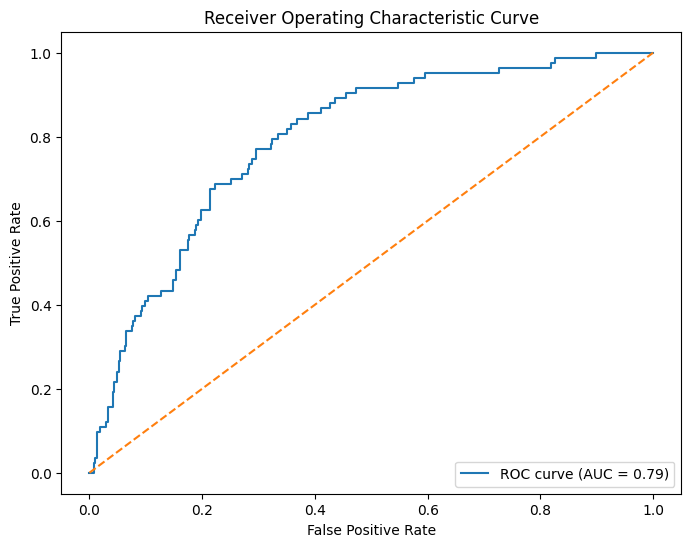

In [15]:
# Evaluation on validation set
y_pred_val = model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
balanced_acc_val = balanced_accuracy_score(y_val, y_pred_val)  # Add balanced accuracy
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f"Validation Accuracy: {accuracy_val}")
print(f"Validation Precision: {precision_val}")
print(f"Validation Recall: {recall_val}")
print(f"Validation F1 Score: {f1_val}")
print(f"Validation Balanced Accuracy: {balanced_acc_val}")  # Print balanced accuracy
print(f"Validation Confusion Matrix: \n{conf_matrix_val}")

# Final evaluation on test set
y_pred_test = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)  # Add balanced accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")
print(f"Test Balanced Accuracy: {balanced_acc_test}")  # Print balanced accuracy
print(f"Test Confusion Matrix: \n{conf_matrix_test}")

# Compute ROC AUC
y_prob_test = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
roc_auc = roc_auc_score(y_test, y_prob_test)
print(f"Test ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()


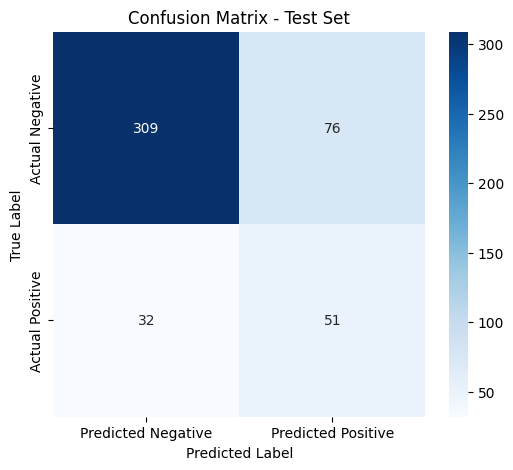

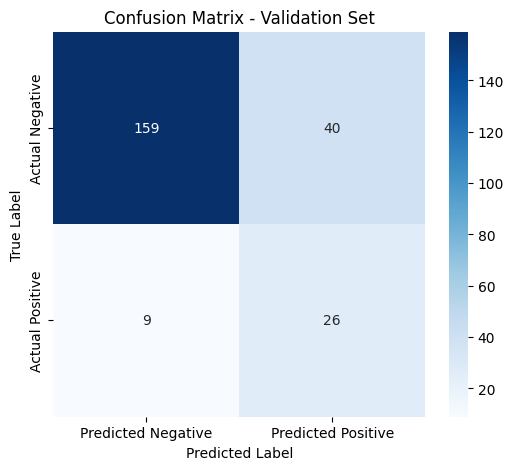

In [16]:
# Plot confusion matrix for test set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot confusion matrix for validation set
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Final Training Score: 0.9084
Final Cross-validation Score: 0.8630


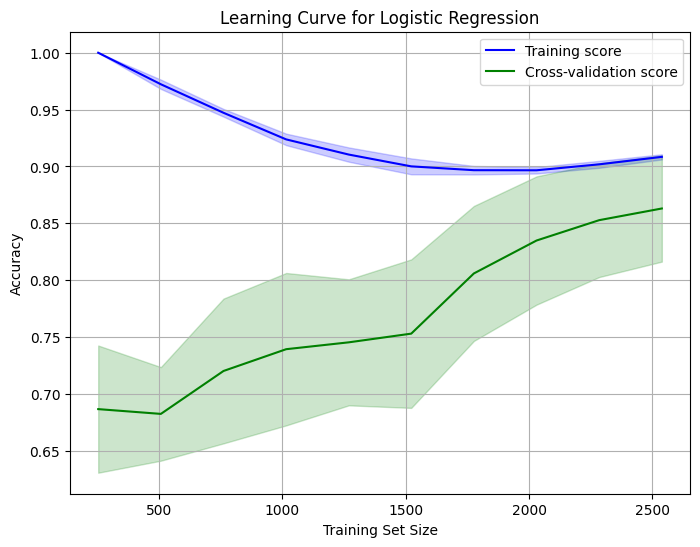

In [17]:
# Assuming you have already defined and resampled your data
# X_train_resampled and y_train_resampled should be your training data and target

# Initialize StratifiedKFold with 5 splits
stratified_cv = StratifiedKFold(n_splits=30)

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_resampled, y_train_resampled, cv=stratified_cv,  # Use StratifiedKFold
    scoring='accuracy',  # Score using accuracy
    train_sizes=np.linspace(0.1, 1.0, 10),  # Training sizes from 10% to 100%
    n_jobs=-1  # Parallel processing
)

# Calculate the mean and standard deviation of train and test scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Print the final scores (for the largest training set size)
print(f"Final Training Score: {train_scores_mean[-1]:.4f}")
print(f"Final Cross-validation Score: {test_scores_mean[-1]:.4f}")

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green')

# Fill the area between the curve and the axis to represent the standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color='green', alpha=0.2)

# Add labels and title
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Logistic Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [18]:
print(test_scores)

[[0.54545455 0.75       0.54545455 0.71590909 0.625      0.68181818
  0.67045455 0.72727273 0.68181818 0.71590909 0.70454545 0.77272727
  0.70454545 0.73863636 0.69318182 0.72727273 0.70114943 0.59770115
  0.71264368 0.71264368 0.68965517 0.72413793 0.68965517 0.67816092
  0.66666667 0.72413793 0.6091954  0.66666667 0.64367816 0.7816092 ]
 [0.64772727 0.65909091 0.56818182 0.65909091 0.64772727 0.65909091
  0.65909091 0.69318182 0.70454545 0.72727273 0.70454545 0.71590909
  0.73863636 0.73863636 0.71590909 0.71590909 0.73563218 0.63218391
  0.73563218 0.67816092 0.71264368 0.71264368 0.67816092 0.63218391
  0.63218391 0.72413793 0.66666667 0.65517241 0.63218391 0.68965517]
 [0.68181818 0.67045455 0.48863636 0.68181818 0.71590909 0.68181818
  0.69318182 0.70454545 0.75       0.78409091 0.72727273 0.77272727
  0.81818182 0.79545455 0.72727273 0.75       0.82758621 0.66666667
  0.77011494 0.72413793 0.71264368 0.72413793 0.75862069 0.74712644
  0.59770115 0.74712644 0.70114943 0.74712644 

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Create StratifiedKFold instance with 30 splits
kf = StratifiedKFold(n_splits=30, shuffle=True, random_state=42)

# List to store test scores for each fold
test_scores = []

# Perform manual K-Fold cross-validation
for train_index, test_index in kf.split(X_train_resampled, y_train_resampled):
    # Split data into train and test based on the indices
    X_train_fold, X_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[test_index]
    
    # Train the model
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the test fold
    y_pred = model.predict(X_test_fold)
    
    # Evaluate using accuracy (since it's classification)
    accuracy = model.score(X_test_fold, y_test_fold)
    
    # Store the accuracy score for this fold
    test_scores.append(accuracy)

# Convert the test scores list into a pandas DataFrame
df_scores = pd.DataFrame(test_scores, columns=['Accuracy'])

# Save the DataFrame to a CSV file
os.makedirs('statistical_treatment', exist_ok=True) 
df_scores.to_csv('statistical_treatment/LOGRES_' + path + '_test_scores.csv', index=False)

# Print the results
print("Test scores for each fold (accuracy):", test_scores)
print("Average accuracy across all folds:", np.mean(test_scores))


Test scores for each fold (accuracy): [0.8636363636363636, 0.8636363636363636, 0.8636363636363636, 0.875, 0.8181818181818182, 0.8522727272727273, 0.8636363636363636, 0.875, 0.875, 0.7386363636363636, 0.8409090909090909, 0.8409090909090909, 0.8181818181818182, 0.875, 0.8295454545454546, 0.8636363636363636, 0.8850574712643678, 0.8850574712643678, 0.8160919540229885, 0.9195402298850575, 0.8735632183908046, 0.8850574712643678, 0.8735632183908046, 0.8390804597701149, 0.8850574712643678, 0.8505747126436781, 0.9310344827586207, 0.8735632183908046, 0.8505747126436781, 0.8390804597701149]
Average accuracy across all folds: 0.8587904911180771


In [20]:
# import pickle
# import numpy as np
# import pandas as pd
# import spacy
# import demoji
# import re
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# from sklearn.linear_model import LogisticRegression
# from nltk.corpus import stopwords

# # Load the pre-trained Spacy model
# nlp = spacy.load("en_core_web_md", disable=["tagger", "parser", "ner"])

# # Load stopwords
# stop_words = set(stopwords.words('english'))

# # Load the pre-trained model
# model_path = "saved_models/English/logistic_regression_English.pkl"
# with open(model_path, 'rb') as model_file:
#     model = pickle.load(model_file)

# # Load the scaler used during training
# scaler_path = "saved_models/Scalers/RegressorScaler_English.pkl"
# with open(scaler_path, 'rb') as scaler_file:
#     scaler = pickle.load(scaler_file)

# # Define text preprocessing function
# def clean_text(text):
#     text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions
#     text = re.sub(r'#\w+', '', text)  # Remove hashtags
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
#     text = demoji.replace_with_desc(text)  # Replace emojis with text
#     text = re.sub(r'(:[a-zA-Z\s]+:)', r' \1 ', text)  # Add spaces around the shortcode
#     text = re.sub(r'(:[a-zA-Z\s]+:)', lambda match: match.group(0).replace(' ', '_'), text)
#     text = text.strip()  # Remove leading/trailing spaces
#     return text

# def remove_stopwords(text):
#     words = text.split()
#     filtered_words = [word for word in words if word.lower() not in stop_words]
#     return ' '.join(filtered_words)

# # Function to extract embeddings from text
# def get_avg_embedding(text):
#     text = clean_text(text)
#     text = remove_stopwords(text)
    
#     # Create embeddings for the clean text using the Spacy model
#     doc = nlp(text)
#     embeddings = [token.vector for token in doc]
#     avg_embedding = np.mean(embeddings, axis=0) if embeddings else np.zeros(300)
    
#     return avg_embedding

# # Function to predict the class of a given tweet
# def predict_sentiment(tweet):
#     # Preprocess the tweet and extract the embeddings
#     avg_embedding = get_avg_embedding(tweet)
    
#     # Scale the embeddings using the saved scaler
#     avg_embedding_scaled = scaler.transform([avg_embedding])

#     # Make the prediction using the model
#     prediction = model.predict(avg_embedding_scaled)
    
#     return prediction[0]

# # Main function to interact with the user
# if __name__ == "__main__":
#     tweet = input("Enter a tweet to predict sentiment: ")
#     prediction = predict_sentiment(tweet)
    
#     # Print the prediction
#     print(f"Predicted sentiment: {prediction}")